# **Система для сбора событий и логов**

ПРЗ 2. Анализ логов

ББМО-02-23 Курченко И.Д.

1. Вариант - 4. HDFS

In [1]:
import math
print (19%16+1)

4


# **1. Клонирование репозитория с логами**

In [2]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 575 (delta 146), reused 136 (delta 133), pack-reused 401 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (267/267), done.


# **2. Парсинг лога и сохранение в СУБД:**

In [14]:
# Выведем первые несколько строк файла для анализа
log_file_path = './loghub/HDFS/HDFS_2k.log'

with open(log_file_path, 'r') as file:
    for _ in range(10):  # Выводим первые 10 строк
        print(file.readline())

081109 203615 148 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_38865049064139660 terminating

081109 203807 222 INFO dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_-6952295868487656571 terminating

081109 204005 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864

081109 204015 308 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_8229193803249955061 terminating

081109 204106 329 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-6670958622368987959 terminating

081109 204132 26 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.43.115:50010 is added to blk_3050920587428079149 size 67108864

081109 204324 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.203.80:50010 is added to blk_7888946331804732825 size 67108864

081109 204453 34 INFO dfs.FSNamesystem:

In [15]:
import re

# Регулярное выражение для парсинга
log_pattern = r'(\d{6}) (\d{6}) (\d+) (\w+) ([\w\.\$\*]+): (.*)'

# Пример парсинга одной строки лога
def parse_hdfs_log_line(line):
    match = re.match(log_pattern, line)
    if match:
        date, time, node, level, component, message = match.groups()
        return {
            'date': date,
            'time': time,
            'node': node,
            'level': level,
            'component': component,
            'message': message
        }
    return None

# Чтение и парсинг логов
log_file_path = './loghub/HDFS/HDFS_2k.log'

parsed_logs = []
with open(log_file_path, 'r') as file:
    for line in file:
        parsed_line = parse_hdfs_log_line(line)
        if parsed_line:
            parsed_logs.append(parsed_line)

# Выводим несколько распарсенных логов для проверки
for log in parsed_logs[:5]:
    print(log)

{'date': '081109', 'time': '203615', 'node': '148', 'level': 'INFO', 'component': 'dfs.DataNode$PacketResponder', 'message': 'PacketResponder 1 for block blk_38865049064139660 terminating'}
{'date': '081109', 'time': '203807', 'node': '222', 'level': 'INFO', 'component': 'dfs.DataNode$PacketResponder', 'message': 'PacketResponder 0 for block blk_-6952295868487656571 terminating'}
{'date': '081109', 'time': '204005', 'node': '35', 'level': 'INFO', 'component': 'dfs.FSNamesystem', 'message': 'BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864'}
{'date': '081109', 'time': '204015', 'node': '308', 'level': 'INFO', 'component': 'dfs.DataNode$PacketResponder', 'message': 'PacketResponder 2 for block blk_8229193803249955061 terminating'}
{'date': '081109', 'time': '204106', 'node': '329', 'level': 'INFO', 'component': 'dfs.DataNode$PacketResponder', 'message': 'PacketResponder 2 for block blk_-6670958622368987959 terminati

In [20]:
import sqlite3

# Подключаемся к базе данных (или создаем новую)
conn = sqlite3.connect('hdfs_logs.db')
cursor = conn.cursor()

# Создаем таблицу для логов
cursor.execute('''
    CREATE TABLE IF NOT EXISTS logs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        time TEXT,
        node TEXT,
        level TEXT,
        component TEXT,
        message TEXT
    )
''')

# Сохраняем изменения
conn.commit()

In [21]:
# Функция для вставки логов в таблицу
def insert_log(log):
    cursor.execute('''
        INSERT INTO logs (date, time, node, level, component, message)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (log['date'], log['time'], log['node'], log['level'], log['component'], log['message']))

# Вставляем распарсенные логи в базу данных
for log in parsed_logs:
    insert_log(log)

# Сохраняем изменения
conn.commit()

In [22]:
# Проверяем, что данные добавлены
cursor.execute('SELECT * FROM logs LIMIT 5')
rows = cursor.fetchall()
for row in rows:
    print(row)

# Закрываем соединение
conn.close()

(1, '081109', '203615', '148', 'INFO', 'dfs.DataNode$PacketResponder', 'PacketResponder 1 for block blk_38865049064139660 terminating')
(2, '081109', '203807', '222', 'INFO', 'dfs.DataNode$PacketResponder', 'PacketResponder 0 for block blk_-6952295868487656571 terminating')
(3, '081109', '204005', '35', 'INFO', 'dfs.FSNamesystem', 'BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864')
(4, '081109', '204015', '308', 'INFO', 'dfs.DataNode$PacketResponder', 'PacketResponder 2 for block blk_8229193803249955061 terminating')
(5, '081109', '204106', '329', 'INFO', 'dfs.DataNode$PacketResponder', 'PacketResponder 2 for block blk_-6670958622368987959 terminating')


# **3. Нормализация логов и сохранение в СУБД:**

In [24]:
import sqlite3
import re

# Функция для нормализации логов
def normalize_log(log):
    return {
        'date': log['date'].strip(),
        'time': log['time'].strip(),
        'node': log['node'].strip(),
        'level': log['level'].strip().lower(),  # Приведение к нижнему регистру
        'component': log['component'].strip(),
        'message': log['message'].strip()
    }

# Подключаемся к базе данных
conn = sqlite3.connect('hdfs_logs.db')
cursor = conn.cursor()

# Удаляем таблицу, если она уже существует
cursor.execute('DROP TABLE IF EXISTS normalized_logs')

# Создаем таблицу для нормализованных логов
cursor.execute('''
    CREATE TABLE normalized_logs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        time TEXT,
        node TEXT,
        level TEXT,
        component TEXT,
        message TEXT
    )
''')

# Нормализуем и сохраняем записи в новую таблицу
for log in parsed_logs:
    normalized_log = normalize_log(log)
    cursor.execute('''
        INSERT INTO normalized_logs (date, time, node, level, component, message)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (normalized_log['date'], normalized_log['time'], normalized_log['node'], normalized_log['level'], normalized_log['component'], normalized_log['message']))

# Сохраняем изменения
conn.commit()

# Проверяем, что данные добавлены в нормализованную таблицу
cursor.execute('SELECT * FROM normalized_logs LIMIT 5')
rows = cursor.fetchall()
for row in rows:
    print(row)

# Закрываем соединение
conn.close()

(1, '081109', '203615', '148', 'info', 'dfs.DataNode$PacketResponder', 'PacketResponder 1 for block blk_38865049064139660 terminating')
(2, '081109', '203807', '222', 'info', 'dfs.DataNode$PacketResponder', 'PacketResponder 0 for block blk_-6952295868487656571 terminating')
(3, '081109', '204005', '35', 'info', 'dfs.FSNamesystem', 'BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864')
(4, '081109', '204015', '308', 'info', 'dfs.DataNode$PacketResponder', 'PacketResponder 2 for block blk_8229193803249955061 terminating')
(5, '081109', '204106', '329', 'info', 'dfs.DataNode$PacketResponder', 'PacketResponder 2 for block blk_-6670958622368987959 terminating')


# **4. Статистический анализ и визуализация:**

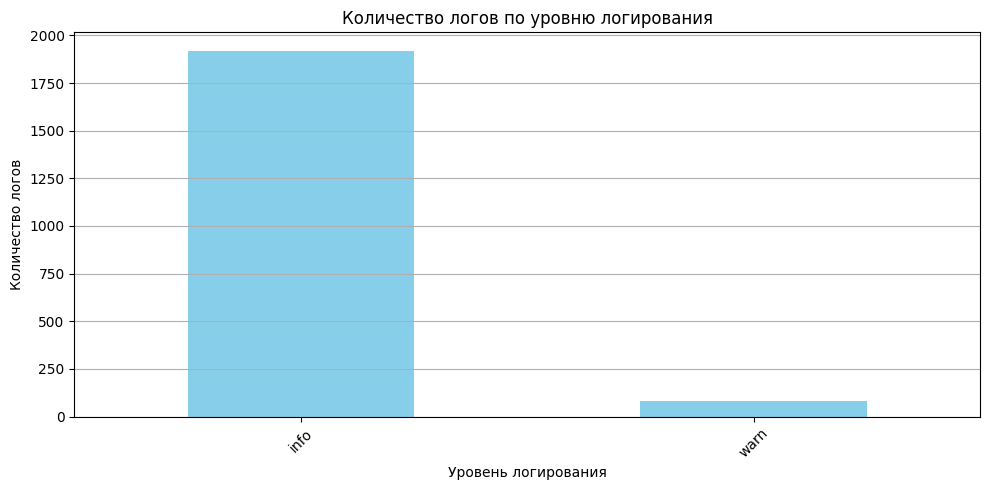

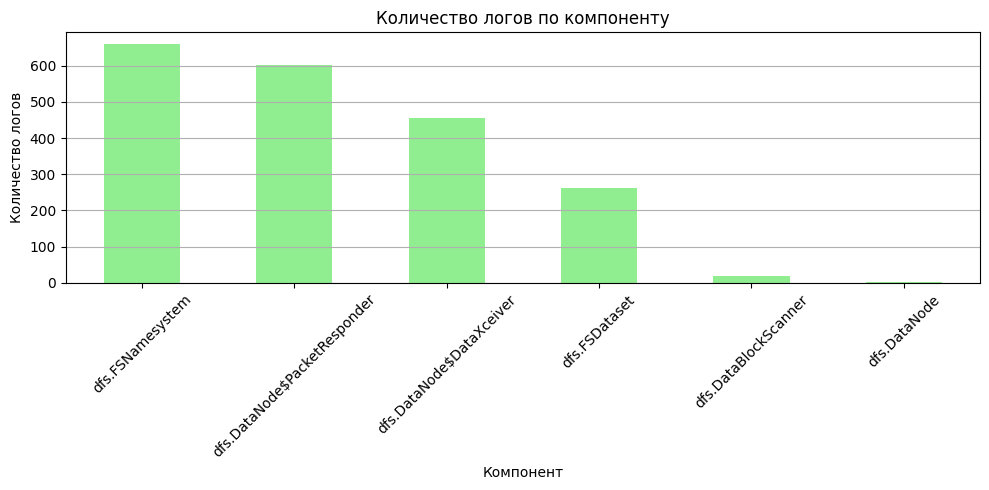

<ipython-input-27-2949e4e57811>:44: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  logs_per_time = df.resample('1T', on='datetime').size()  # 1T — 1 минута


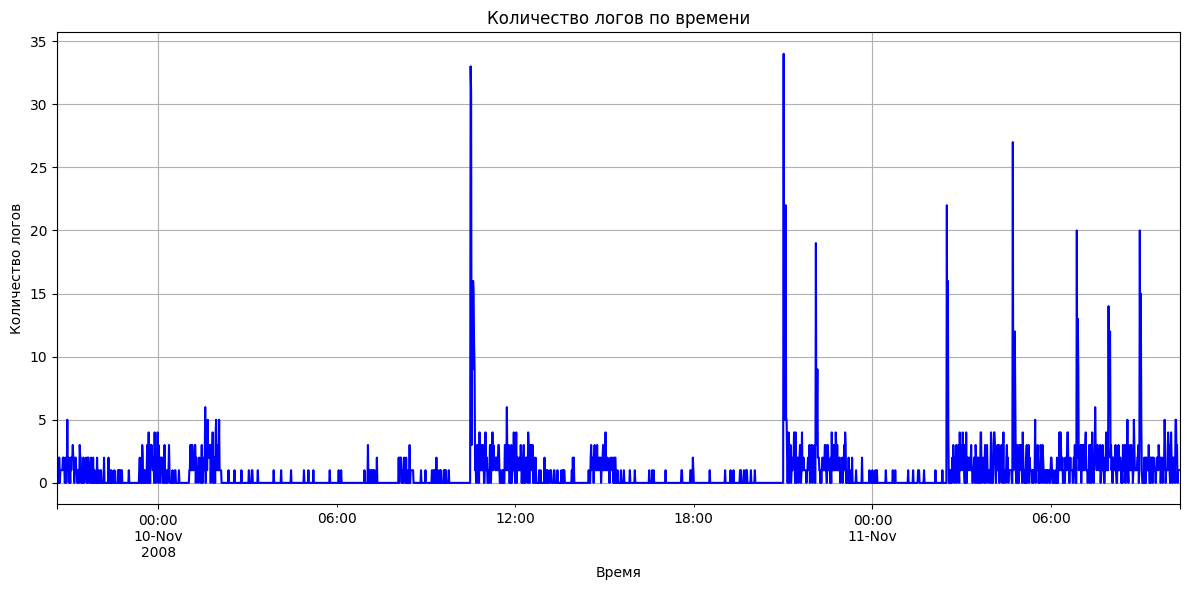

In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Подключаемся к базе данных
conn = sqlite3.connect('hdfs_logs.db')

# Читаем нормализованные логи в DataFrame
df = pd.read_sql_query('SELECT * FROM normalized_logs', conn)

# Статистический анализ
# Подсчет количества логов по уровню логирования
level_counts = df['level'].value_counts()

# Подсчет количества логов по компоненту
component_counts = df['component'].value_counts()

# Визуализация количества логов по уровню логирования
plt.figure(figsize=(10, 5))
level_counts.plot(kind='bar', color='skyblue')
plt.title('Количество логов по уровню логирования')
plt.xlabel('Уровень логирования')
plt.ylabel('Количество логов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Визуализация количества логов по компоненту
plt.figure(figsize=(10, 5))
component_counts.plot(kind='bar', color='lightgreen')
plt.title('Количество логов по компоненту')
plt.xlabel('Компонент')
plt.ylabel('Количество логов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Добавим столбец с полным временем
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M%S')

# Подсчет логов по времени
logs_per_time = df.resample('1T', on='datetime').size()  # 1T — 1 минута

# Визуализация логов по времени
plt.figure(figsize=(12, 6))
logs_per_time.plot(color='blue')
plt.title('Количество логов по времени')
plt.xlabel('Время')
plt.ylabel('Количество логов')
plt.grid()
plt.tight_layout()
plt.show()


# Закрываем соединение
conn.close()